In [2]:
from pyspark.sql import SparkSession

# IMPORTANT: absolute path to your JDBC driver
jdbc_path = "/Users/joshuaflood/Repos/smart-store-joshua/lib/sqlite-jdbc.jar"

spark = (
    SparkSession.builder
    .appName("SmartStoreReporting")
    .config("spark.driver.extraClassPath", jdbc_path)
    .getOrCreate()
)

spark

ModuleNotFoundError: No module named 'pyspark'

In [1]:
from pyspark.sql import SparkSession

jdbc_path = "/Users/joshuaflood/Repos/smart-store-joshua/lib/sqlite-jdbc.jar"

spark = (
    SparkSession.builder
    .appName("SmartStoreReporting")
    .config("spark.driver.extraClassPath", jdbc_path)
    .getOrCreate()
)

spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/21 19:10:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql import SparkSession

jdbc_path = "/Users/joshuaflood/Repos/smart-store-joshua/lib/sqlite-jdbc.jar"

spark = (
    SparkSession.builder
    .appName("SmartStoreReporting")
    .config("spark.driver.extraClassPath", jdbc_path)
    .getOrCreate()
)

dw_path = "/Users/joshuaflood/Repos/smart-store-joshua/data_warehouse/datawarehouse.db"

sales_df = spark.read.format("jdbc").options(
    url=f"jdbc:sqlite:{dw_path}",
    dbtable="sale"
).load()

sales_df.show(5)

+-------+-----------+----------+---------------+---------+------------+
|sale_id|customer_id|product_id|sale_amount_usd|sale_date|payment_type|
+-------+-----------+----------+---------------+---------+------------+
|      1|       1034|      2059|         2048.2|   5/4/25|      Credit|
|      2|       1066|      2048|         321.87|   5/4/25|      Credit|
|      3|       1116|      2041|        3216.84|   5/4/25|      Credit|
|      4|       1071|      2096|        1613.23|   5/4/25|    GiftCard|
|      5|       1020|      2060|         408.38|   5/4/25|      PayPal|
+-------+-----------+----------+---------------+---------+------------+
only showing top 5 rows


In [3]:
customer_df = spark.read.format("jdbc").options(
    url=f"jdbc:sqlite:{dw_path}",
    dbtable="customer"
).load()

product_df = spark.read.format("jdbc").options(
    url=f"jdbc:sqlite:{dw_path}",
    dbtable="product"
).load()

customer_df.show(5)
product_df.show(5)

+-----------+-------------+-------+---------+-----------------+------------------+
|customer_id|         name| region|join_date|open_invoices_num|retention_category|
+-----------+-------------+-------+---------+-----------------+------------------+
|       1000| Robert Gomez|   West|  2/25/24|                8|         Recovered|
|       1001|   John Silva|   East|  12/1/20|                0|         Recovered|
|       1002|Mark Marshall|Central|   8/8/20|                6|               New|
|       1003|David Brennan|  North|  5/21/20|                2|         Recovered|
|       1004|Kerry Collins|  North|  9/12/23|                4|         Recovered|
+-----------+-------------+-------+---------+-----------------+------------------+
only showing top 5 rows
+----------+--------------------+-----------+--------------+------------+------------+
|product_id|        product_name|   category|unit_price_usd|restock_days|    supplier|
+----------+--------------------+-----------+----------

In [4]:
sales_df.createOrReplaceTempView("sale")
customer_df.createOrReplaceTempView("customer")
product_df.createOrReplaceTempView("product")

In [5]:
slice_df = spark.sql("""
    SELECT *
    FROM sale
    WHERE payment_type = 'Credit'
""")
slice_df.show(10)

+-------+-----------+----------+---------------+---------+------------+
|sale_id|customer_id|product_id|sale_amount_usd|sale_date|payment_type|
+-------+-----------+----------+---------------+---------+------------+
|      1|       1034|      2059|         2048.2|   5/4/25|      Credit|
|      2|       1066|      2048|         321.87|   5/4/25|      Credit|
|      3|       1116|      2041|        3216.84|   5/4/25|      Credit|
|     10|       1119|      2089|         661.63|   5/4/25|      Credit|
|     11|       1042|      2077|         505.65|   5/4/25|      Credit|
|     15|       1026|      2089|         413.52|   5/4/25|      Credit|
|     16|       1144|      2005|        1715.12|   5/4/25|      Credit|
|     19|       1110|      2046|          30.09|   5/4/25|      Credit|
|     20|       1111|      2022|         671.18|   5/4/25|      Credit|
|     23|       1062|      2096|         672.18|   5/4/25|      Credit|
+-------+-----------+----------+---------------+---------+------

In [6]:
dice_df = spark.sql("""
    SELECT c.region,
           s.payment_type,
           p.category,
           SUM(s.sale_amount_usd) AS total_sales
    FROM sale s
    JOIN customer c ON s.customer_id = c.customer_id
    JOIN product p ON s.product_id = p.product_id
    WHERE c.region = 'South'
      AND s.payment_type = 'Credit'
    GROUP BY c.region, s.payment_type, p.category
""")
dice_df.show()

+------+------------+-----------+------------------+
|region|payment_type|   category|       total_sales|
+------+------------+-----------+------------------+
| South|      Credit|     Office|          12460.32|
| South|      Credit|   Clothing|11904.590000000002|
| South|      Credit|       Home| 9747.819999999998|
| South|      Credit|Electronics| 7549.389999999999|
+------+------------+-----------+------------------+



In [7]:
drill_df = spark.sql("""
    SELECT c.region,
           s.payment_type,
           p.category,
           SUM(s.sale_amount_usd) AS total_sales
    FROM sale s
    JOIN customer c ON s.customer_id = c.customer_id
    JOIN product p ON s.product_id = p.product_id
    GROUP BY ROLLUP (c.region, s.payment_type, p.category)
""")
drill_df.show()

+----------+------------+-----------+------------------+
|    region|payment_type|   category|       total_sales|
+----------+------------+-----------+------------------+
|     South|      PayPal|       Home|          15142.53|
|     North|      PayPal|Electronics|           19461.7|
|   Central|      PayPal|     Office|11550.810000000001|
|   Central|        Cash|Electronics| 9042.519999999999|
|     South|      Credit|       Home|           9747.82|
|south-west|      Credit|Electronics|            7769.4|
|south-west|    GiftCard|Electronics|14548.570000000002|
|      EAST|      Credit|       NULL| 51963.77000000001|
|   Central|      PayPal|   Clothing|15329.289999999999|
|     South|      Credit|Electronics| 7549.389999999999|
|     North|    GiftCard|       NULL|110216.83999999998|
|south-west|      PayPal|       NULL| 49296.56000000001|
|      NULL|        NULL|       NULL|2026974.5200000014|
|      EAST|      PayPal|     Office|          17164.16|
|      East|      Credit|      

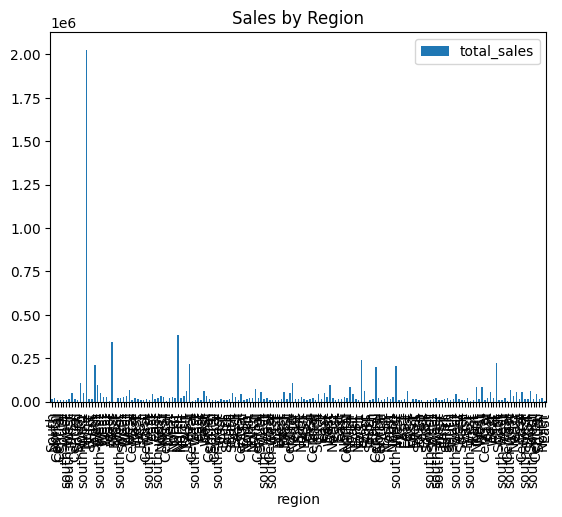

25/11/21 19:31:38 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 187996 ms exceeds timeout 120000 ms
25/11/21 19:31:38 WARN SparkContext: Killing executors is not supported by current scheduler.
25/11/21 19:31:41 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:669)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1296)
	at o

In [8]:
import matplotlib.pyplot as plt

pdf = drill_df.toPandas()

pdf.plot(kind="bar", x="region", y="total_sales")
plt.title("Sales by Region")
plt.show()